In [1]:
import numpy as np
from fractions import Fraction
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

In [2]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))
def simMul(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}*{y_val} mod {N} = ${(x_val*y_val)%N }_{{10}}$ = ${((x_val*y_val)%N):0{n_qubits}b}_{{2}}$ "))
def simMulExp(circuit, simulator, shots,x_val,y_val,a,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}*{y_val}^{a} mod {N} = ${(x_val*y_val**a)%N }_{{10}}$ = ${((x_val*y_val**a)%N):0{n_qubits}b}_{{2}}$ "))


def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [3]:
def adder(n_qubits,y):
    qr = QuantumRegister(n_qubits,name="q")
    qc = QuantumCircuit(qr,name="Add")
    qft = QFT(n_qubits, do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(n_qubits):
            theta = 2 * np.pi*y / (2 ** (i + 1))
            qc.p(theta, qr[i])
    # Apply inverse QFT 
    iqft = QFT(n_qubits, do_swaps=False).inverse()
    qc.append(iqft, qr)

    return qc.to_instruction()

In [4]:
def isLess(n_qubits,y):
    """
    the last 2 qubits are a and c respectivly , the other are the data register , the final result is saved in c.
    """
    qubits = list(range(n_qubits))
    x = qubits[:-2]
    a = qubits[-2]
    c = qubits[-1]
    qc = QuantumCircuit(n_qubits,name="isLess")
    add_plus_y = adder(n_qubits-1,y)
    add_minus_y = adder(n_qubits-1,-y)
    qc.append(add_minus_y, x+ [a])
    qc.cx(a,c)
    qc.append(add_plus_y, x+ [a])
    return qc.to_instruction()

In [5]:
def Cadder(n_qubits,y):
    """
    the first qubit is the control qubit, the rest are data qubits
    """
    qr = QuantumRegister(n_qubits-1,name="q")
    control = QuantumRegister(1,name="control")
    qc = QuantumCircuit(control,qr,name="CAdd")
    qft = QFT(n_qubits-1, do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(n_qubits-1):
            theta = 2 * np.pi*y / (2 ** (i + 1))
            qc.cp(theta,control, qr[i])
    # Apply inverse QFT 
    iqft = QFT(n_qubits-1, do_swaps=False).inverse()
    qc.append(iqft, qr)

    return qc.to_instruction()

In [6]:
def CisLess(n_qubits,y):
    """
    needs n+3 qubits for n bit number
    the first qubit is the control, qubit,the last 2 qubits are a and c respectivly , the other are the data register , the final result is saved in c.
    """

    qubits = list(range(n_qubits))
    control = qubits[0]
    x = qubits[1:-2]
    a = qubits[-2]
    c = qubits[-1]
    qc = QuantumCircuit(n_qubits,name="isLess")
    add_plus_y = Cadder(n_qubits-1,y)
    add_minus_y = Cadder(n_qubits-1,-y)
    qc.append(add_minus_y,[control]+ x+ [a])
    qc.cx(a,c)
    qc.append(add_plus_y, [control]+x+ [a])
    return qc.to_instruction()

In [7]:
def CaddModN(n_qubits, y,N):
    
    """
    needs n+4 qubits for an n bit long number
    the first qubit is the control, qubit,the last 3 qubits are a , c1 and c2 respectivly , the other are the data register , the final result is saved in c.
    """
    qubits = list(range(n_qubits))
    control = qubits[0]
    x = qubits[1:-3]
    a = qubits[-3]
    c1 = qubits[-2]
    c2 = qubits[-1]
    y = y%N
    

    qc = QuantumCircuit(n_qubits,name="CaddModN")
    isLess_N = CisLess(n_qubits-1,N)
    isLess_N_minus_y = CisLess(n_qubits-1,N-y)
    isLess_y = CisLess(n_qubits-1,y)
    add_y_minus_N = Cadder(n_qubits-3,y-N) #need to be with control a
    add_y = Cadder(n_qubits-3,y) #need to be with control a
    qc.append(isLess_N,[control]+x+[a]+[c1])
    qc.append(isLess_N_minus_y,[control]+x+[a]+[c2])

    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)
    qc.append(add_y_minus_N,[a]+x)
    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)

    qc.ccx(c1,c2,a)
    qc.append(add_y,[a]+x)
    qc.ccx(c1,c2,a)


    qc.append(isLess_y,[control]+x+[a]+[c2])
    qc.cx(c1,c2)
    qc.append(isLess_N,[control]+x+[a]+[c1])
    return qc.to_instruction()


In [8]:
x_val =9
y_val = 1
N_val=11
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 

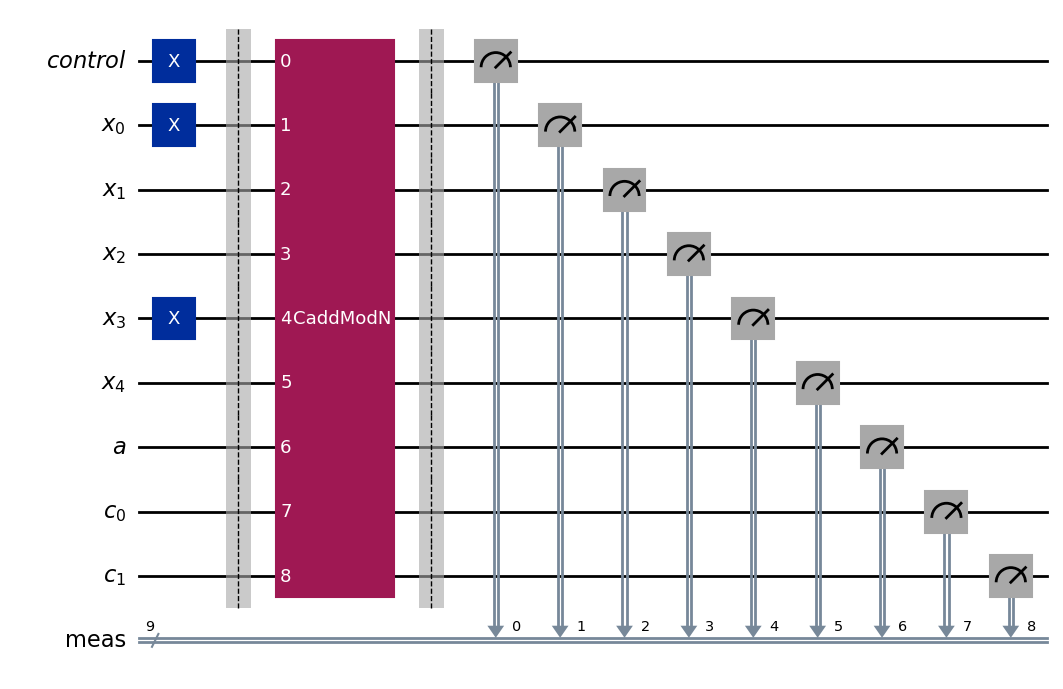

In [9]:
qr = QuantumRegister(n_qubits,'x')
a = QuantumRegister(1,'a')
c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
circ = QuantumCircuit(control,qr,a,c)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ.x(qr[i])
circ.x(control)
circ.barrier()

circ.append(CaddModN(n_qubits+4,y_val,N_val),circ.qubits[:])
circ.measure_all()
circ.draw('mpl')


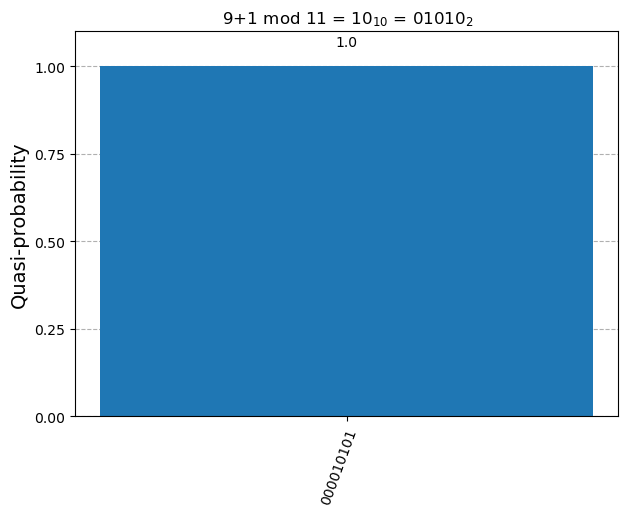

In [10]:
sim(circ,AerSimulator(),1000,x_val,y_val,N_val,5)

In [11]:
def summands(y,N,n_qubits):
    r = np.zeros(n_qubits)
    for i in range(0,n_qubits):
        s = 0
        for j in range(0,n_qubits):
            s = s+int(np.binary_repr(y,n_qubits)[::-1][j])*2**(i+j)
        r[i] = s % N
    return r

In [12]:
def eEa(a,b):
    if (a==0): 
        return (b,0,1)
    gcd, x,y, = eEa(b%a,a)
    return (gcd,y-(b//a)*x,x)

def moduloinverse(a,n):
    gcd, x,_ = eEa(a,n)
    if gcd !=1:
        raise VauleError("Mod inverse does not exists")
    return x%n

In [13]:
def CmultModN(n_qubits,y,N):
    """
    needs a 1+n+n+4 qubits for n qubit number
    with the layout control+data+2nd data,auxillary
    """
    qubits = list(range(n_qubits))
    n = (n_qubits-5)//2 
    control = qubits[0:1]      # length 1
    x1 = qubits[1:n+1]   # length n
    x2 = qubits[(n+1):2*n+1] # length n  
    a = qubits[(2*n+1):]
    s = summands(y,N,n)

    qc = QuantumCircuit(n_qubits,name=f"Cmult {y} Mod{N}")

    for i in range(n):
        qc.ccx(control,x1[i],a[3])
        qc.append(CaddModN(n+4,s[i],N),[a[3]]+x2+[a[2]]+a[0:2])
        qc.ccx(control,x1[i],a[3])
    for i in range(n):
        qc.cswap(control,x1[i],x2[i])
    y_inv  = N-moduloinverse(y,N)
    s_inv = summands(y_inv,N,n)
    for i in range(n):
        qc.ccx(control,x1[i],a[3])
        qc.append(CaddModN(n+4,s_inv[i],N),[a[3]]+x2+[a[2]]+a[0:2])
        qc.ccx(control,x1[i],a[3])
    return qc.to_instruction()

In [14]:
x_val =9
y_val = 2
N_val=11
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 
n_qubits

5

In [15]:
qr = QuantumRegister(n_qubits,'x')
qr1 = QuantumRegister(n_qubits,'z')
a = QuantumRegister(4,'a')
# c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
circ1 = QuantumCircuit(control,qr,qr1,a)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ1.x(qr[i])
circ1.h(control[0])
circ1.barrier()
circ1.append(CmultModN(circ1.num_qubits,y_val,N_val),circ1.qubits)
circ1.measure_all()

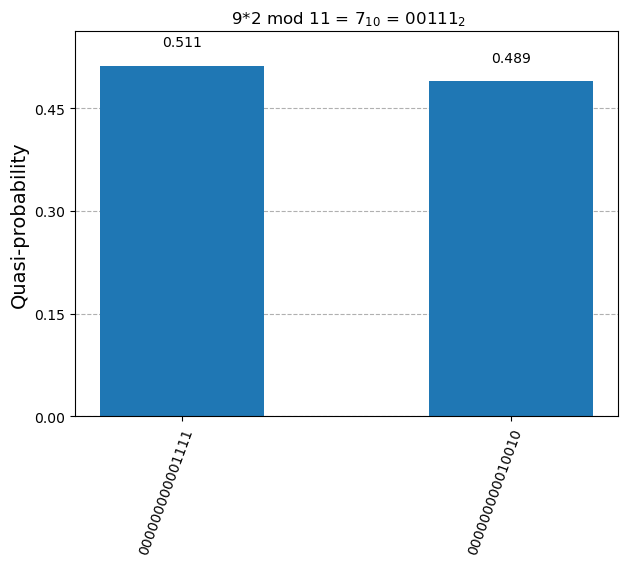

In [16]:
simMul(circ1,AerSimulator(),1000,x_val,y_val,N_val,n_qubits)

In [17]:
def CexpModN(n_qubits,y,a1,N):
    qubits = list(range(n_qubits))
    n = (n_qubits-5)//2 
    control = qubits[0:1]      # length 1
    x1 = qubits[1:n+1]   # length n
    x2 = qubits[(n+1):2*n+1] # length n  
    a = qubits[(2*n+1):]
    qc = QuantumCircuit(n_qubits,name=rf"C ${y}^{a1}$ Mod${N}$")
    gate = CmultModN(1+n+n+4,y,N)
    for _ in range(a1):
        qc.append(gate,control+x1+x2+a)
    return qc.to_instruction()

In [18]:
x_val =1
y_val = 3
N_val=7
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 
n_qubits

4

In [19]:
qr = QuantumRegister(n_qubits,'x')
qr1 = QuantumRegister(n_qubits,'z')
a = QuantumRegister(4,'a')
# c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
circ2 = QuantumCircuit(control,qr,qr1,a)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ2.x(qr[i])
circ2.x(control[0])
circ2.barrier()
circ2.append(CexpModN(circ2.num_qubits,y_val,2**3,N_val),circ2.qubits)
circ2.measure_all()

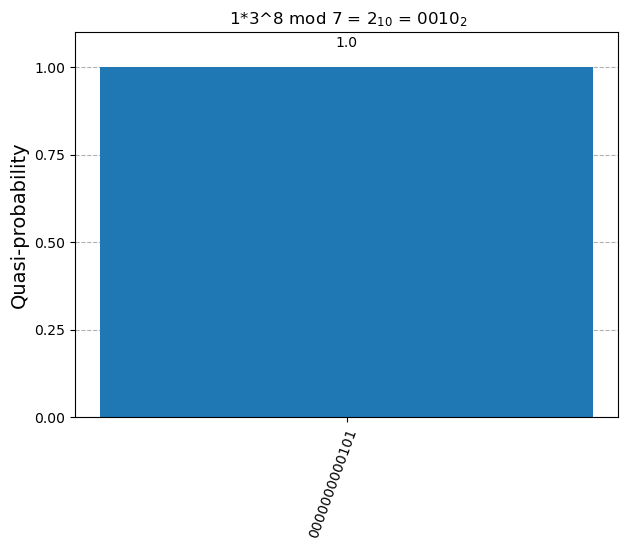

In [20]:
simMulExp(circ2, AerSimulator(), 1024,x_val,y_val,2**3,N_val,n_qubits)

In [21]:
# circ1.decompose().draw('mpl')

In [21]:
def phase_estimation(n_qubits,t,n,m,N):
    """
    expectsd a circuit of t+n+n+4 qubits

    with registers qr, qrL,qrL2,a

    qr is the uper part of the phase estimation
    qrL is the lower part, here is the result of the multimlication saved
    qrL2 are the helper qubits of qrL
    a are the anchillas
    
    """
    qubits = list(range(n_qubits))
    qr = qubits[:t]
    qrL = qubits[t:t+n]
    qrL2 = qubits[t+n: t+2*n]
    a = qubits[t+2*n:]
    qc = QuantumCircuit(n_qubits,t,name="Phase Estimation")
    qc.h(qr)
    qc.x(qrL[0]) #hier muss eigenlich 0 hin
    for i in range(t):
        gate = CmultModN(1+n+n+4,m,N)
        for _ in range(2**i):
            qc.append(gate,[qr[i]]+qrL+qrL2+a)
    qc.append(QFT(t, inverse=True),qr)
    qc.measure(qr,qc.clbits)
    return qc.to_instruction()

In [22]:
n = 3
t = 2*n +3
# t=2

In [23]:
qr = QuantumRegister(t,'t') #these are the top qubits of the phase estimation algorithem
qrL = QuantumRegister(n,'L') #here the multiplication is done we need n for the result, n for zwischen result and 4 anchillas
qrL2 = QuantumRegister(n,'L2')
a = QuantumRegister(4,'a') 
cl = ClassicalRegister(t)
# cl1 = ClassicalRegister(n)
qc = QuantumCircuit(qr,qrL,qrL2,a,cl)
qc.append(phase_estimation(t+n+n+4,t,n,3,7),qc.qubits,cl)
# qc.measure_all()

In [25]:
# qc.decompose().draw('mpl')

In [24]:
result = simGetCounts(qc,AerSimulator(),10000)

In [25]:
result

{'001110000': 1,
 '101111010': 1,
 '010110100': 1,
 '100010011': 1,
 '110011010': 1,
 '000110111': 1,
 '101100110': 1,
 '101100011': 1,
 '001000000': 1,
 '010010010': 1,
 '110100000': 1,
 '001100101': 1,
 '011011000': 1,
 '000010111': 1,
 '001001100': 1,
 '101001110': 3,
 '010100110': 3,
 '001010110': 265,
 '100101100': 1,
 '010000001': 1,
 '101010011': 18,
 '001100001': 2,
 '110100110': 3,
 '111111010': 1,
 '100111000': 1,
 '001011011': 5,
 '110100100': 3,
 '110110000': 3,
 '110000100': 1,
 '110101111': 7,
 '110110001': 5,
 '001011100': 4,
 '101011011': 2,
 '001001011': 2,
 '101011010': 4,
 '010101111': 7,
 '101010000': 5,
 '010101000': 17,
 '101100111': 1,
 '110001101': 1,
 '101011001': 9,
 '101001100': 1,
 '110101011': 1129,
 '100000000': 1708,
 '110101000': 16,
 '110111110': 1,
 '010001111': 1,
 '001010101': 1126,
 '110101001': 50,
 '001011001': 15,
 '001100100': 3,
 '010100010': 1,
 '101010110': 327,
 '001010100': 76,
 '101010001': 4,
 '001001101': 1,
 '001100000': 2,
 '101010010'

In [26]:
def continued_fraction_iterative(x, iter):
    if iter == 0 or isinstance(x, int):
        return int(np.floor(x))
    
    # Store the terms in reverse order
    terms = []
    current_x = x
    
    # Calculate all floor values first
    for _ in range(iter):
        floor_val = int(np.floor(current_x))
        terms.append(floor_val)
        
        # Break if we have a whole number
        if np.mod(current_x, 1) == 0:
            break
            
        current_x = 1/np.mod(current_x, 1)
    
    # Build the fraction from bottom up
    result = terms[-1]  # Start with the last term
    
    # Work backwards through the terms
    for term in reversed(terms[:-1]):
        result = term + Fraction(1, result)
    
    return result

In [27]:
def get_order(phi,x,N):
    k=1
    estimated_r = continued_fraction_iterative(phi,k)
    while estimated_r.denominator<N and  k< 1000:
        r = estimated_r.denominator
        if pow(x,r,N) == 1:
            print(f"{k} itertations where needed")
            return r
        k+=1
        estimated_r = continued_fraction_iterative(phi,k)

In [28]:
orders = []
for i in result:
    order = get_order(int(i,2)/2**t,3,7)
    if  isinstance(order,int):
        orders.append(order)

2 itertations where needed
3 itertations where needed
4 itertations where needed
3 itertations where needed
4 itertations where needed
3 itertations where needed
3 itertations where needed
3 itertations where needed
3 itertations where needed
2 itertations where needed
3 itertations where needed
4 itertations where needed
2 itertations where needed
4 itertations where needed
3 itertations where needed
2 itertations where needed
2 itertations where needed
4 itertations where needed
3 itertations where needed
3 itertations where needed
4 itertations where needed
3 itertations where needed
3 itertations where needed
2 itertations where needed
2 itertations where needed
3 itertations where needed
2 itertations where needed
2 itertations where needed
3 itertations where needed
3 itertations where needed
4 itertations where needed
4 itertations where needed
3 itertations where needed
2 itertations where needed
2 itertations where needed
2 itertations where needed
3 itertations where needed
3

In [29]:
orders

[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

In [30]:
np.lcm.reduce(orders)

np.int64(6)

In [31]:
len(orders)/len(result)*100

26.573426573426573